# MICOM Visualization
* This is the jupyter for visualization of model simulation
* We can draw heatmap, predicted growth, 
* Further details please find here https://micom-dev.github.io/micom/viz.html

In [13]:
#install packages
# !pip install openpyxl==3.1.5
# !pip install micom==0.37.1
# !pip install pandas==2.3.3
# !pip install cobra==0.29.1
# !pip install seaborn


#import packages
import pandas as pd
import pickle, openpyxl, cobra
import re, micom
from micom.workflows import grow
from micom import Community, data
from micom import load_pickle
from micom.viz import *
import warnings
import seaborn as sns
from scipy.cluster.hierarchy import linkage, leaves_list
import matplotlib as plt
warnings.filterwarnings("ignore")

### Import and Export data
* Pickle data: We will perform visualization on the already-simulated data (pickle data)
* Pickle data should be under '/pickle' directory


* various output data

In [2]:
#Input the growth pickle here.
output_name = "yunusbayev_genus_0.01_FBA_0.5"


#Phenotype (control & healthy)
metadata = pd.read_csv("input/"+ "yunusbayev_metadata.csv")  #Input here
phenotype = metadata["host_disease"]
phenotype.index = metadata["sample"]


growth_results = pickle.load(open(f"growth_pickle/{output_name}.pickle", "rb"))

In [3]:
#processing & filtering growth rate data, just run this code. 

gr_data = growth_results.growth_rates
gr_data.index = [i for i in range(len(gr_data.index))]
gr_data = gr_data.drop(["reactions", "metabolites", "tradeoff"], axis=1)
gr_data = gr_data.reindex(columns=["taxon","sample_id", "abundance", "growth_rate"] )
gr_data["host_disease"] = [phenotype[i] for i in gr_data["sample_id"]]

taxon_list  = gr_data["taxon"].unique()
sample_list  = gr_data["sample_id"].unique()

gr_data_processed =  pd.DataFrame(index=sample_list, columns=taxon_list)

#allign them into stoichiometrics
for i in gr_data.index:
    taxon = gr_data.loc[i, "taxon"]
    sample = gr_data.loc[i, "sample_id"]
    gr = gr_data.loc[i, "growth_rate"]
    gr_data_processed[taxon][sample] = gr

gr_data_processed = gr_data_processed.reindex(gr_data_processed.mean(skipna=True).sort_values(ascending=False).index, axis=1)
#filter out columns with count(x==a) less than 5
gr_data_processed  = gr_data_processed.loc[:, (gr_data_processed > 0).sum() >= 10]
taxon_list = gr_data_processed.columns




### 1. Growth rates

#### 1-1. MICOM built-in growth rate plot
* Plot the growth rates of each taxa
* Color can be specific to taxon/phenotype

In [4]:
#MiCOM built-in growth rate plot.

# set this to true if you want growth rate's hue based on phenotype.
phenotype_color = True

if phenotype_color == True:
    plot_growth(growth_results, groups=phenotype, filename=f"visualization/growth_rate/{output_name}_gr.html")
else:
    plot_growth(growth_results, filename=f"visualization/growth_rate/{output_name}_gr.html")

#### 1-2 Custom seaborn plot
* Plot all taxa

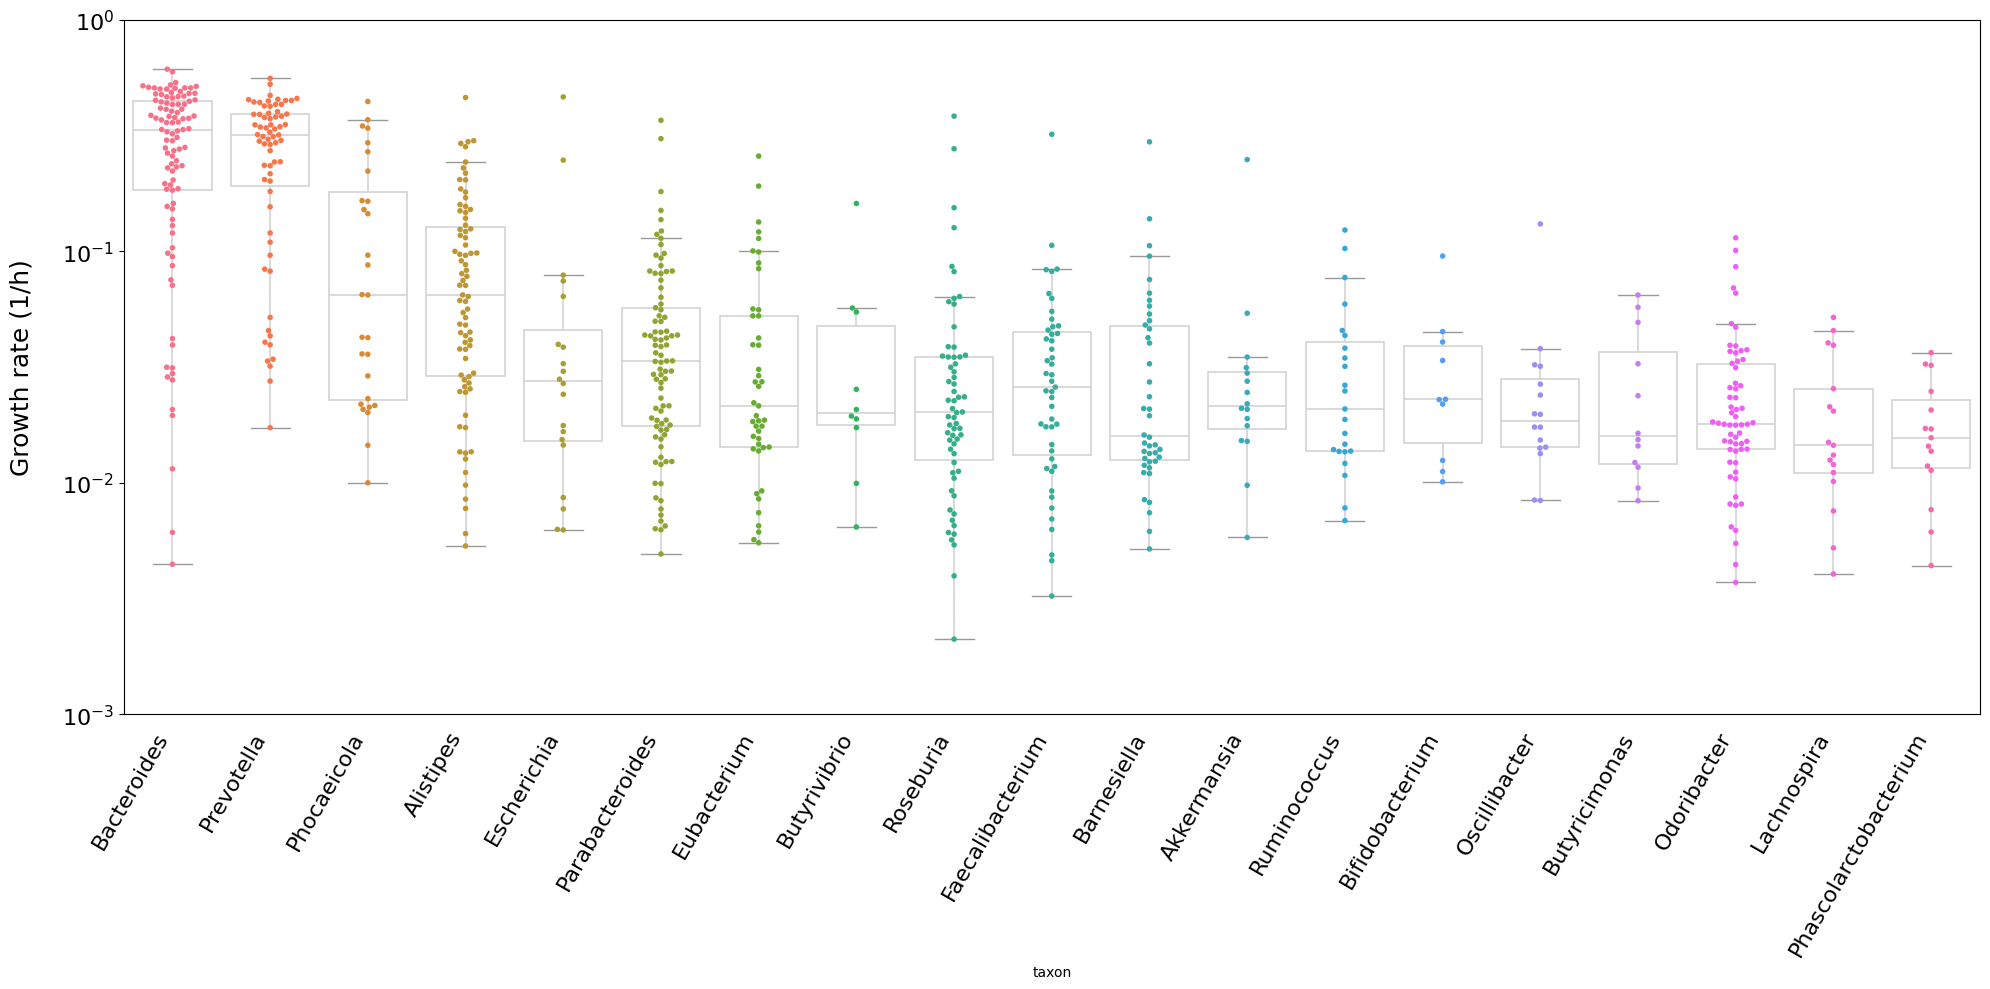

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# gr_data_melted: columns ["taxon", "gr"]
gr_data_melted  = gr_data_processed.melt( var_name="taxon", value_name="gr")
# ---- sort taxa by mean gr ----
order = (
    gr_data_melted
    .groupby("taxon")["gr"]
    .mean()
    .sort_values(ascending=False)              # smallest mean at left; use descending=True for reverse
    .index
    .tolist()
)

# one color per taxon, in this sorted order
palette = sns.color_palette("husl", n_colors=len(order))
palette_dict = dict(zip(order, palette))

fig, ax = plt.subplots(figsize=(20, 10))

# optional neutral boxplot
sns.boxplot(
    data=gr_data_melted,
    x="taxon", y="gr",
    order=order,
    ax=ax,
    color="white",
    width=0.8,
    boxprops=dict(linewidth=1.2, edgecolor="lightgray"),
    whiskerprops=dict(linewidth=1.2, color="lightgray"),
    medianprops=dict(linewidth=1.2, color="lightgray"),
    showcaps=True,
    showfliers=False
)

# colored swarm, one color per taxon
sns.swarmplot(
    data=gr_data_melted,
    x="taxon", y="gr",
    order=order,
    hue="taxon",
    palette=palette_dict,
    dodge=False,
    size=4,
    alpha=1,
    ax=ax,
    legend=False
)

ax.set_yscale("log", base=10)
ax.set_ylim(1e-3, 1e0)
ax.margins(y=0)
plt.autoscale(False)


ax.set_ylabel("Growth rate (1/h)", size=18, labelpad=20)

ax.tick_params(axis="both", which="both", labelsize=16)
ax.tick_params(axis="x", which="both", bottom=False, top=False, length=0, pad=10)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right")
ax.minorticks_off()

ax.spines["right"].set_visible(True)
ax.spines["top"].set_visible(True)

plt.tight_layout()
#plt.savefig(f"visualization/growth_rate/{output_name}_gr.png", dpi=300, bbox_inches="tight") 
plt.show()


* Plot both control & diseased.

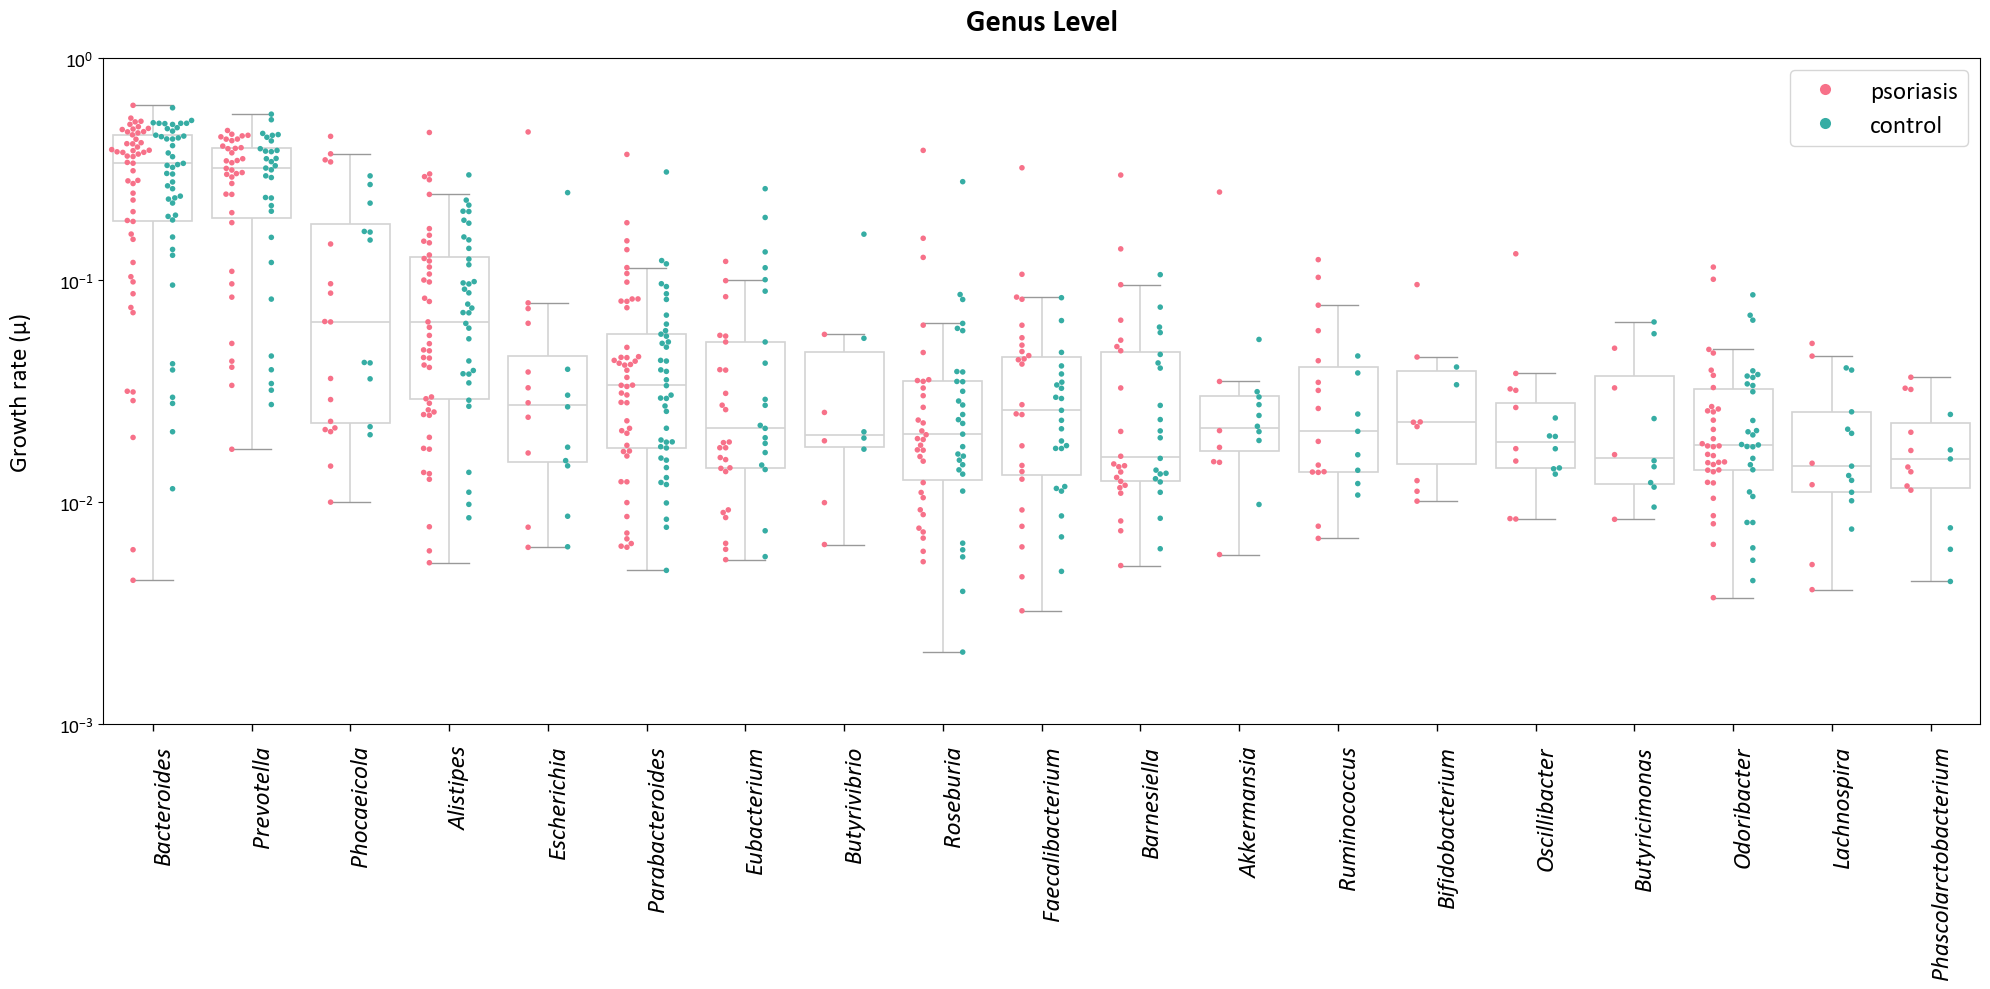

In [6]:
gr_data_processed["type"] = [phenotype[i] for i in gr_data_processed.index]
plt.rcParams["font.family"] = "Calibri"


# ---- melt: keep 'type' as an id var ----
# assumes gr_data_processed has a column named "type"
gr_data_melted = gr_data_processed.melt(
    id_vars="type",      # keep this column
    var_name="taxon",
    value_name="gr"
)

#remove "_"
gr_data_melted["taxon"] = [i.replace("_", " ") for i in gr_data_melted["taxon"] ]


# ---- sort taxa by mean gr (over all types) ----
order = (
    gr_data_melted
    .groupby("taxon")["gr"]
    .mean()
    .sort_values(ascending=False)      # largest mean at left
    .index
    .tolist()
)

# one color per type (not per taxon)
type_order = gr_data_melted["type"].unique().tolist()
palette = sns.color_palette("husl", n_colors=len(type_order))
palette_dict = dict(zip(type_order, palette))

fig, ax = plt.subplots(figsize=(20, 10))

# neutral boxplot per taxon
sns.boxplot(
    data=gr_data_melted,
    x="taxon", y="gr",
    order=order,
    ax=ax,
    color="white",
    width=0.8,
    boxprops=dict(linewidth=1.2, edgecolor="lightgray"),
    whiskerprops=dict(linewidth=1.2, color="lightgray"),
    medianprops=dict(linewidth=1.2, color="lightgray"),
    showcaps=True,
    showfliers=False
)

# colored swarm: hue = type
sns.swarmplot(
    data=gr_data_melted,
    x="taxon", y="gr",
    order=order,
    hue="type",
    hue_order=type_order,
    palette=palette_dict,
    dodge=True,      # separate types within each taxon
    size=4,
    alpha=1,
    ax=ax
)

ax.set_yscale("log", base=10)
ax.set_ylim(1e-3, 1e0)
ax.margins(y=0)
plt.autoscale(False)


#set title, x,y axis label
ax.set_title("Genus Level", fontsize=22, pad=20, fontweight="bold")
ax.set_xlabel(r"")
ax.set_ylabel(r"Growth rate (μ)", size=18, labelpad=20)

ax.tick_params(axis="both", which="both", labelsize=14)
ax.tick_params(axis="x", which="both", labelsize=18)
ax.tick_params(axis="x", which="both", bottom=True, top=False, length=5,width=1, pad=10)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

# make x-ticks italic
for label in ax.get_xticklabels():
    label.set_fontstyle("italic")


ax.minorticks_off()
ax.spines["right"].set_visible(True)
ax.spines["top"].set_visible(True)

#legend
ax.legend( fontsize=18, title_fontsize=18, markerscale=2.0)

plt.tight_layout()
plt.show()


### 2. Metabolites
#### 2-1. Metabolites import/export Heatmap
* Heatmap plot for metabolites consumption/production.
* You can either plot the metabolic fluxes of metabolites that are exported/imported.
* Also can cluster specific lists of subjects together.

In [17]:
# metabolite direction (import / export)
direction = "export"

# If you want similiar metabolic flux patterns to cluster together.
cluster = True

# If you want specific subjects to cluster together, activate below code (remove #)  
#samples_to_cluster = ["D36_profile", "D37_profile","D50_profile", "D55_profile", "D32_profile", "D61_profile", "D62_profile", "D57_profile", "D66_profile"]


In [20]:
#---- Just run this code,, don't change from below-----
filename=f"visualization/metabolites/{output_name}_{direction}.html"
exchanges = growth_results.exchanges.copy()
anns = growth_results.annotations.copy().drop_duplicates(subset="metabolite")
anns.index = anns.metabolite
tol = exchanges.tolerance.iloc[0]
if direction not in ["import", "export"]:
    ValueError("Not a valid flux direction. Must be `import` or `export`. ")
exchanges = exchanges[
    (exchanges.taxon == "medium")
    & (exchanges.direction == direction)
    & (exchanges.flux.abs() > tol)
].copy()
exchanges.flux = exchanges.flux.abs()
mat = exchanges.pivot_table(
    values="flux", index="metabolite", columns="sample_id", fill_value=tol
)

if cluster:
    sample_order = leaves_list(linkage(mat.values.T, method="average"))
else:
    sample_order = range(mat.shape[1])
reaction_order = leaves_list(linkage(mat.values, method="average"))
mat = mat.iloc[reaction_order, sample_order]



#cluster the samples in arrangement
samples_list = metadata.iloc[:,0].to_list()
filtered_sample_list = [i for i in samples_list if i in mat.columns ]
mat = mat.reindex(columns = filtered_sample_list)
######################
mat["metabolite"] = mat.index


#cluster the picked samples
try:
    samples_to_cluster
except AttributeError:
    pass
except NameError:
    pass
else:
    
    for sample in filtered_sample_list:
        if sample not in samples_to_cluster:
            samples_to_cluster.append(sample)

    
    mat = mat.reindex(columns = samples_to_cluster)
    mat["metabolite"] = mat.index



# melt to visualization
data = mat.melt(id_vars="metabolite", var_name="sample_id", value_name="flux")
data["description"] = anns.loc[data.metabolite, "name"].values
data = {"exchange_fluxes": data}
viz = Visualization(filename, data, "sample_heatmap.html")
long = mat.shape[0] > mat.shape[1]
w = mat.shape[1] * 10 if long else mat.shape[0] * 10
height = mat.shape[0] * 10 if long else mat.shape[1] * 10
height = mat.shape[0]*10
w = mat.shape[1] * 10
long =True


viz.save(
    data=data["exchange_fluxes"].to_json(orient="records"),
    width=w,
    height=height,
    long=long,
)

#### 2-2. T-SNE Metabolites import/export patterns 
* Draw a T-SNE plot for either metabolite import/export patterns of each subjects.
* T-SNE that are closer together imply similar patterns.

In [ ]:
# metabolite direction (import / export)
direction = "import"

# T-SNE Perflexity
perflexity = 5


#---- version 1: color based on taxon ----
# 
plot_exchanges_per_taxon(growth_results, perplexity=perflexity, direction=direction , filename=f"visualization/metabolites/TSNE_{output_name}_{direction}.html")#, groups=phenotype)

##---- version 2: color based on phenotype 
#plot_exchanges_per_taxon(growth_results, perplexity=perflexity, direction=direction , filename=f"visualization/metabolites/TSNE_{output_name}_{direction}.html", groups=phenotype)